In [1]:
from imutils.perspective import four_point_transform
import matplotlib.pyplot as plt
import pytesseract
import imutils
import cv2
import re
import requests
import numpy as np

In [2]:
def plt_imshow(title="image", img=None, figsize=(8,5)):
    plt.figure(figsize=figsize)
    
    if type(img) == list:
        if type(title) == list:
            titles = title
        else :
            titles=[]
            
            for i in range(len(img)):
                titles.append(title)
                
        for i in range(len(img)):
            if len(img[i].shape) <= 2:
                rgbImg = cv2.cvtColor(img[i], cv2.COLOR_GRAY2RGB)
            else:
                rgbImg = cv2.cvtColor(img[i], cv2.COLOR_BGR2RGB)
                
            plt.subplot(1, len(img), i+1), plt.imshow(rgbImg)
            plt.title(titles[i])
            plt.xticks([]), plt.yticks([])
        
        plt.show()
    else:
        if len(img.shape) < 3:
            rgbImg = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
        else :
            rgbImg = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        plt.imshow(rgbImg)
        plt.title(title)
        plt.xticks([]), plt.yticks([])
        plt.show()

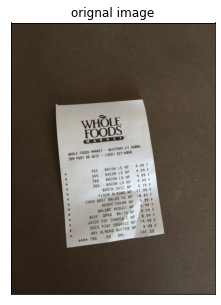

In [3]:
url = 'https://user-images.githubusercontent.com/69428232/148330274-237d9b23-4a79-4416-8ef1-bb7b2b52edc4.jpg'
 
image_nparray = np.asarray(bytearray(requests.get(url).content), dtype=np.uint8)
org_image = cv2.imdecode(image_nparray, cv2.IMREAD_COLOR) 
 
plt_imshow("orignal image", org_image)

In [4]:
image = org_image.copy()
image = imutils.resize(image, width=500)
ratio = org_image.shape[1] / float(image.shape[1])

In [5]:
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
blurred = cv2.GaussianBlur(gray, (5, 5,), 0)
edged = cv2.Canny(blurred, 75, 200)

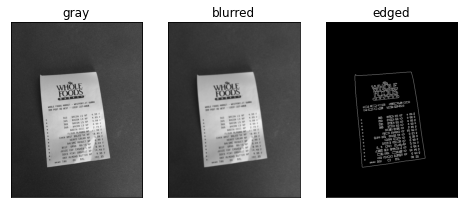

In [6]:
plt_imshow(['gray', 'blurred', "edged"], [gray, blurred, edged])

In [7]:
cnts = cv2.findContours(edged.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)
cnts = sorted(cnts, key=cv2.contourArea, reverse=True)

In [8]:
for c in cnts:
    peri = cv2.arcLength(c, True)
    approx = cv2.approxPolyDP(c, 0.02*peri, True)
    
    if len(approx)==4:
        receiptCnt = approx
        break

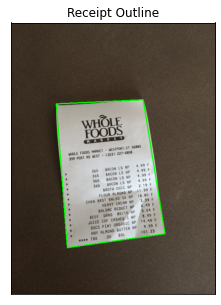

In [9]:
if receiptCnt is None:
    raise Exception(("Could not find receipt outline."))
    
output = image.copy()
cv2.drawContours(output, [receiptCnt], -1, (0, 255, 0), 2)
plt_imshow("Receipt Outline", output)

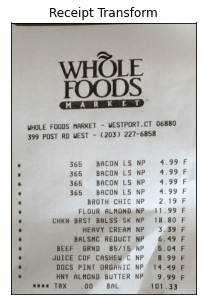

In [10]:
receipt = four_point_transform(org_image, receiptCnt.reshape(4, 2) * ratio)
plt_imshow("Receipt Transform", receipt)

In [11]:
options = "--psm 4"
text = pytesseract.image_to_string(cv2.cvtColor(receipt, cv2.COLOR_BGR2RGB), config=options)

In [12]:
print("[INFO] OCR결과:")
print("===============")
print(text)
print("\n")

[INFO] OCR결과:
WHOLE
FOODS

WHOLE FOODS MARKET - WESTPORT, CT 06880
399 POST RD WEST - (203) 227-6858

365 BACON LS NP 4.99

365 BACON LS NP 4.99

365 BACON LS NP 4,99

365 BACON LS NP 4.99
BROTH CHIC NP 4.5

FLOUR ALMOND NP 11.99

CHKN BRST BNLSS SK NP 18.80
HEAVY CREAM NP 3.39

BALSMC REDUCT NP 6.49

BEEF GRND 85/15 NP 5.04
JUICE COF CASHEW C NP 8.99
DOCS PINT ORGANIC NP 14.49
HNY ALMOND BUTTER NP 9.99
eee TAX .00 BAL 101.33





In [13]:
gray = cv2.cvtColor(receipt, cv2.COLOR_BGR2GRAY)
(H, W)=gray.shape

In [14]:
rectKernel = cv2.getStructuringElement(cv2.MORPH_RECT, (30, 20))
sqKernel=cv2.getStructuringElement(cv2.MORPH_RECT, (50, 21))

In [15]:
gray = cv2.GaussianBlur(gray, (11, 11), 0)
blackhat = cv2.morphologyEx(gray, cv2.MORPH_BLACKHAT, rectKernel)

In [17]:
grad = cv2.Sobel(blackhat, ddepth=cv2.CV_32F, dx=1, dy=0, ksize=-1)
grad = np.absolute(grad)
(minVal, maxVal) = (np.min(grad), np.max(grad))
grad = (grad - minVal) / (maxVal - minVal)
grad = (grad * 255).astype("uint8")

In [18]:
grad = cv2.morphologyEx(grad, cv2.MORPH_CLOSE, rectKernel)
thresh = cv2.threshold(grad, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]

In [21]:
close_thresh = cv2.morphologyEx(grad, cv2.MORPH_CLOSE, sqKernel)
close_thresh = cv2.erode(close_thresh, None, iterations=2)

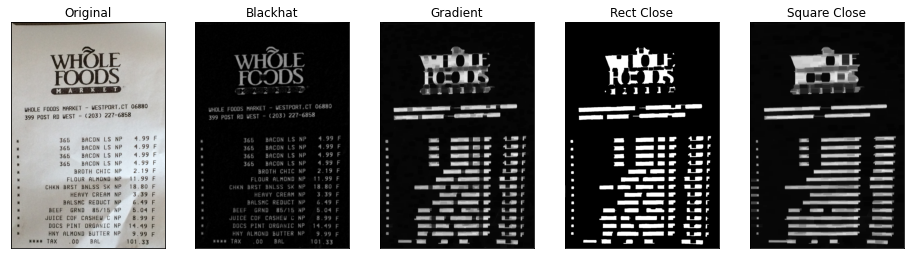

In [22]:
plt_imshow(["Original", "Blackhat", "Gradient", "Rect Close", "Square Close"], [receipt, blackhat, grad, thresh, close_thresh], figsize=(16,10))

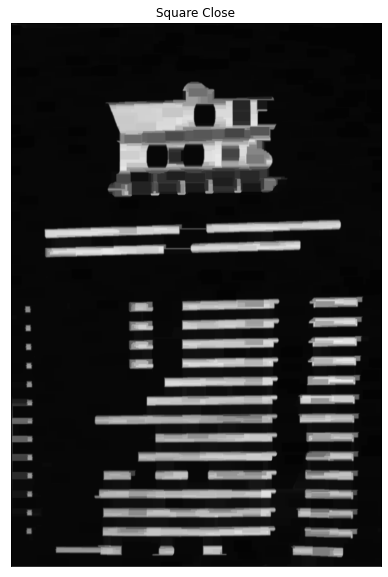

In [23]:
plt_imshow(["Square Close"], [close_thresh], figsize=(16,10))